In [1]:
using Pkg

In [2]:
Pkg.activate(dirname(pwd()))

  Activating project at `~/Documents/GitHub/ComputationalHeatTransfer.jl`


In [3]:
using ComputationalHeatTransfer
using LaTeXStrings
using JLD2
using Plots
gr()  


┌ Info: Precompiling ComputationalHeatTransfer [5fc296c8-2eb5-40dc-a46d-98a68011a900]
└ @ Base loading.jl:1662


Plots.GRBackend()

## Control Console

In [36]:
OHPtype = "ASETS-II OHP 2 LARGE HEATER"
power = 40 #watts
hc = 3000.0 #condenser heat transfer coefficient
Rn = 3e-6 # nucleation site radius
δfilm = 2e-5 # initial film thickness
ad_fac = 1.3 # film thickness factor
plate_d = 1.5e-3; # plate thickness
Eratio_plus = 0.15 + 0.5 # η+
Eratio_minus = 0.15 # η-

0.15

# Properies

### Solid Physical parameters

In [37]:
ρₛ = 2730; # density
cₛ  = 8.93e02; # specific heat
kₛ  = 1.93e02; # heat conductivity
params = HeatConductionParameters(ρₛ ,cₛ ,kₛ ,thickness=plate_d)

HeatConductionParameters(2730.0, 893.0, 193.0, 7.916682048820907e-5, 0.0015)

### Fluid Physical parameters

In [38]:
Tref = 291.2 # reference temperature
fluid_type = "Butane"
p_fluid = SaturationFluidProperty(fluid_type,Tref);

# Plate Conduction Part

### Geometry parameters

In [39]:
Lx = 0.1524; # plate size x
Ly = 0.0648; # plate size y
xlim = (-Lx/2,Lx/2) # plate x limits
ylim = (-Ly/2,Ly/2) # plate y limits

(-0.0324, 0.0324)

### Set mesh size and maximum time step

In [40]:
Δx,Δt_max = setstepsizes(params.α,gridPe=8.0,fourier=0.3) 

(0.0006333345639056725, 0.001520002953373614)

### Set up the evaporators and condensers

In [41]:
Tc = Tref; # condenser temperature
eparams,cparams = OHPConfiguration(OHPtype,power,Tc,hc,Δx,hc2ratio=1/30);

# Set up OHP channel's shape

In [42]:
x, y = construct_ohp_curve("ASETS",Δx) # get x and y coordinates for the channel
ohp = BasicBody(x,y) # build a BasicBody based on x,y
ohpgeom = ComputationalHeatTransfer.LineSourceParams(ohp);

# Create HeatConduction system

In [43]:
sys = HeatConduction(params,Δx,xlim,ylim,Δt_max,qline=ohpgeom,qflux=eparams,qmodel=cparams)

Unbounded Heat conduction system on a grid of size 250 x 112 and 0 static immersed points


# Create OHP inner channel system, initial state vector, and callback function

In [44]:
sys_tube,u,cbst = initialize_ohpsys(OHPtype,fluid_type,sys,p_fluid,Tref,δfilm,Eratio_plus,Eratio_minus,Rn);

### set time step

In [31]:
tspan = (0.0, 1.0);
dt_record = 0.01
num_data = tspan[2] / dt_record

tstep = 5e-4

0.0005

### combine inner tube and plate together

In [32]:
u_plate = newstate(sys) .+ Tref # initialize T field
integrator_plate = init(u_plate,tspan,sys)

t: 0.0
u: (Primal nodes in a (nx = 256, ny = 120) cell grid of type Float64 data
  Number of Primal nodes: (nx = 255, ny = 119), Float64[])

In [45]:
prob = ODEProblem(ODE_innertube, u, tspan, sys_tube)
integrator_tube = init(prob, RK4(),save_on=false, dt=tstep, callback=cbst)

t: 0.0
u: 2321-element Vector{Float64}:
   1.4320487416006793
   1.5382311013368173
   1.5870710832285966
   1.6489133669271732
   1.7420934248565139
   1.811091583412848
   1.8971157664844314
   1.9462579965230526
   2.0521381081123486
   2.1045832590287823
   2.207160449740266
   2.2603221734926255
   2.362182791368183
   ⋮
 291.2
 291.2
 291.2
 291.2
 291.2
 291.2
 291.2
 291.2
 291.2
 291.2
 291.2
 291.2

## Resume

In [34]:
# integrator_plate = integrator_plate_temp;

In [35]:
# integrator_tube = tube_hist[end];

## Start

In [18]:
boil_hist=[]
plate_T_hist = []
tube_hist_u  = []
tube_hist_t = []
tube_hist_θwall = []

Any[]

In [19]:
using Distributed
using ProgressMeter

In [20]:
@showprogress for t in tspan[1]:tstep:tspan[2]

    timemarching!(integrator_tube,integrator_plate,tstep)
    
    if (mod(integrator_plate.t,dt_record) < 1e-6) || (mod(-integrator_plate.t,dt_record) < 1e-6)
        push!(plate_T_hist,deepcopy(temperature(integrator_plate))); 
        push!(tube_hist_θwall,deepcopy(integrator_tube.p.wall.θarray))
        push!(tube_hist_u,deepcopy(integrator_tube.u));
        push!(tube_hist_t,deepcopy(integrator_tube.t));
        integrator_plate_temp = deepcopy(integrator_plate)
#         println(sys.qline[1].q[1:5])
    end
    
end
# integrator_plate.t

Progress: 100%|█████████████████████████████████████████| Time: 0:00:50


In [22]:
boil_hist

Any[]

In [23]:
sysfinal = []
for i = 1:length(tube_hist_u)
    sysfinaltemp = deepcopy(getcurrentsys(tube_hist_u[i],integrator_tube.p))
    sysfinaltemp.wall.θarray = tube_hist_θwall[i]
    push!(sysfinal, sysfinaltemp)
end

┌ Info: Saved animation to /Users/yuxuanli/Documents/GitHub/ComputationalHeatTransfer.jl/notebooks/slug_fps15.gif
└ @ Plots /Users/yuxuanli/.julia/packages/Plots/nuwp4/src/animation.jl:156


Plots.AnimatedGif("/Users/yuxuanli/Documents/GitHub/ComputationalHeatTransfer.jl/notebooks/slug_fps15.gif")
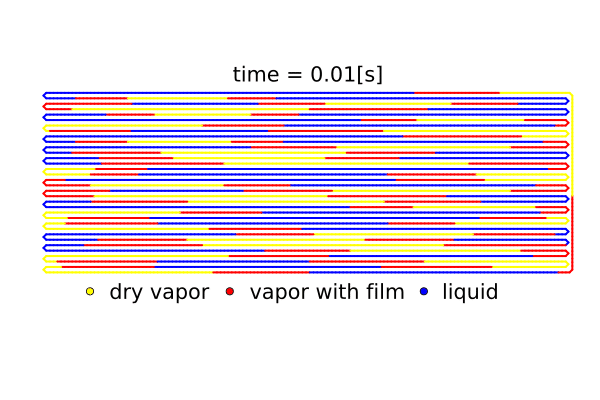

In [25]:
gr()
Hₗ = sysfinal[1].liquid.Hₗ
adjust = 1e-2;

anim = @animate for i=1:length(sysfinal)
    Htmp = sys_to_Harray(sysfinal[i])
    Htmp_marker = round.(div.(Htmp,Hₗ-1e-10))
    plot(ohp,clim=(0,2),fillalpha=0,linewidth=2.0,linecolor=palette([:yellow,  :blue, :red]),
        line_z=Htmp_marker,xlabel="x ",ylabel="y ",border=:none,axis=nothing,bbox_inches="tight")
        annotate!(0.0, 0.028, string("time = ", round(tube_hist_t[i], digits=2), "[s]"), :black,legend=false)
    scatter!([-0.066+adjust],[-0.028],color=:yellow);scatter!([-0.03+adjust],[-0.028],color=:red);scatter!([0.02+adjust],[-0.028],color=:blue);
    annotate!(-0.05+0.002+adjust, -0.028, "dry vapor", :black)
    annotate!(-0.01+0.005+adjust, -0.028, "vapor with film", :black)
    annotate!(0.03+0.002+adjust, -0.028, "liquid", :black)
end
gif(anim, "slug_fps15.gif", fps = 10)

┌ Info: Saved animation to /Users/yuxuanli/Documents/GitHub/ComputationalHeatTransfer.jl/notebooks/temperature_fps15.gif
└ @ Plots /Users/yuxuanli/.julia/packages/Plots/nuwp4/src/animation.jl:156


Plots.AnimatedGif("/Users/yuxuanli/Documents/GitHub/ComputationalHeatTransfer.jl/notebooks/temperature_fps15.gif")
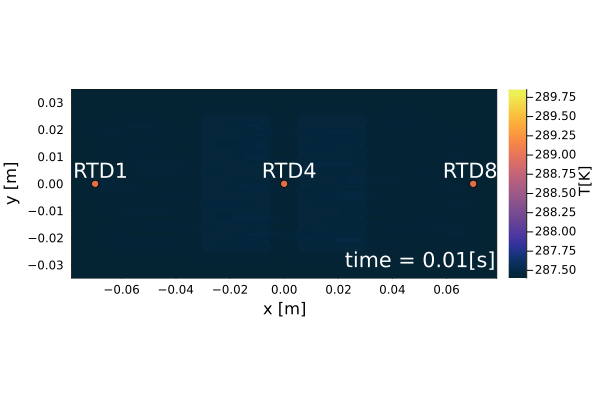

In [26]:
    x = [-2.75inch,-1.4inch,-0.8inch,0.0,0.0,0.8inch,1.4inch,2.75inch]
    y = [0.0,0.0,0.0,0.0,0.4inch,0.0,0.0,0.0];
gr()
Tmax = maximum(plate_T_hist[end]) .- 3.8
Tmin = minimum(plate_T_hist[1]) .- 3.8
xlim = integrator_plate.p.grid.xlim[1]
ylim = integrator_plate.p.grid.xlim[2]

anim = @animate for i = 1:1:length(sysfinal)
# @gif for i = 1:1:1
heatmap(plate_T_hist[i].- 3.8,sys.grid,legend=true,color=cgrad(:thermal),
        xlimit=xlim,ylimit=ylim,clim=(Tmin,Tmax),line_z=0,xlabel="x [m]",ylabel="y [m]",
        colorbar_title = "\n T[K]",right_margin = 5Plots.mm)
scatter!([x[1],x[4],x[8]],[y[1],y[4],y[8]])
annotate!(x[1]+0.002, y[1]+0.005, "RTD1", :white)
annotate!(x[4]+0.002, y[4]+0.005, "RTD4", :white)
annotate!(x[8]-0.001, y[8]+0.005, "RTD8", :white)
annotate!(0.05, -0.028, string("time = ", round(tube_hist_t[i], digits=2), "[s]"), :white,legend=false)
end
gif(anim, "temperature_fps15.gif", fps = 10)

## Store data

In [ ]:
using JLD2

In [ ]:
boil_station_hist = [elem[1] for elem in boil_hist]
boil_t_hist = [elem[2] for elem in boil_hist]
boil_data = Array(reshape([boil_station_hist;boil_t_hist], length(boil_t_hist),2));

In [ ]:
save(dirname(dirname(dirname(pwd())))*"/OHPnume/OHP2_40W_large.jld2",
    "tube_hist_θwall", tube_hist_θwall,"tube_hist_u", tube_hist_u,"tube_hist_t", tube_hist_t,
    "integrator_tube",integrator_tube,"plate_T_hist", plate_T_hist,
    "integrator_plate", integrator_plate, "boil_data", boil_data,"ohp",ohp)

In [ ]:
boiltime_stations

In [ ]:
using XLSX
# namei = "20190604_F_PD_%23005_O002_H001_P010_expA.xlsx"
# namei = "20190606_F_PD_%23006_O002_H001_P020_expA.xlsx"
# namei = "20190612_F_PD_%23007_O002_H001_P030_expA.xlsx"
namei = "20190613_F_PD_%23008_O002_H001_P040_expA.xlsx"
# namei = "20190613_F_PD_%23004_O001_H001_P040_expA.xlsx"
# namei = "20190612_F_PD_%23003_O001_H001_P030_expA.xlsx"
# namei =     "20190604_F_PD_%23001_O001_H001_P010_expA.xlsx";
#  namei =    "20190606_F_PD_%23002_O001_H001_P020_expA.xlsx";

xf = XLSX.readxlsx(dirname(dirname(dirname(pwd())))*"/OHPexp/"*namei)
    Onum, Hnum, power_exp = getconfig(namei)
    RTD,RTDt = getRTD(xf,Onum);

In [ ]:
    x = [-2.9inch,-1.4inch,-0.8inch,0.0,0.0,0.8inch,1.4inch,2.9inch]
    y = [0.0,0.0,0.0,0.0,0.4inch,0.0,0.0,0.0];
    X =  VectorData(x,y);
    H = Regularize(X,cellsize(sys),I0=origin(sys.grid))
    g = ScalarData(X);
    ghist = getghist(g,H,plate_T_hist);
    thist = tube_hist_t;

In [ ]:
Tᵥ = Tref

# dryout case, high htc for condenser adiabatic side

In [ ]:
pyplot()
i = 1 #RTD number

p1 = plot(thist,ghist[i] .-Tᵥ, color=:red, label=string("RTD", i," simulation"),linewidth=2,legend = :topleft)
scatter!(RTDt .- RTDt[1],RTD[:,i] .- RTD[1,i], color=:red, label=string("RTD", i," experiment"))

i = 4 #RTD number

p1 = plot!(thist,ghist[i] .-Tᵥ, color=:green, label=string("RTD", i," simulation"),linewidth=2,legend = :topleft)
scatter!(RTDt .- RTDt[1],RTD[:,i] .- RTD[1,i], color=:green, label=string("RTD", i," experiment"))

i = 8 #RTD number
plot!(thist,ghist[i] .-Tᵥ,color=:orange,label=string("RTD", i," simulation"),linewidth=2)
scatter!(RTDt .- RTDt[1],RTD[:,i] .- RTD[1,i], color=:orange, label=string("RTD", i," experiment"),
    xlabel="time [s]",ylabel="T-T₀ [K]",xlim=(0,200),ylim=(0,50),title=("temperature curve: OHP2 large heater"))

savefig(p1,"temp_curve.pdf")

In [ ]:
M1 = sum.(getMvapor.(sysfinal));
M2 = sum.(sum.(getMfilm.(sysfinal)));
M3 = sum.(getMliquid.(sysfinal));
Mtotal = M1 .+ M2 .+ M3;
M0 = Mtotal[1]
plot(Mtotal/M0,ylim=(0.999,1.001))

In [ ]:
M2

In [ ]:
M3